## This notebook in nutshell

* Multimodal Deep Learning
    * Image
    * Text
* Dynamic image augmentation rate
    * GridMask image augmentation (https://arxiv.org/abs/2001.04086)
    * Rotate, shear, zoom, shift from [Rotation Augmentation GPU/TPU - [0.96+]](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)
    * [tf.image](https://www.tensorflow.org/api_docs/python/tf/image) functions
* TF-IDF word representation
    * L2 normalization
    * Sublinear Term Frequency
* EfficientNet B7 (https://arxiv.org/abs/1905.11946)
* LAMB optimizer (https://arxiv.org/abs/1904.00962)
* Global Average Pooling (https://arxiv.org/abs/1312.4400)
* TPU

## Changelog

* Version 2 : ?
    * Change LR
    * Optimize GridMask to use TPU
    * Remove unused codes
    * Merge code from https://www.kaggle.com/williammulianto/fork-of-kernel42b295af53?scriptVersionId=37641353
* Version 1 : 0.15254
    * Make sure there's no error

## Install, load and configure library

In [1]:
!pip install --upgrade efficientnet tensorflow_addons tensorflow

Requirement already up-to-date: tensorflow_addons in /opt/conda/lib/python3.7/site-packages (0.10.0)
Requirement already up-to-date: tensorflow in /opt/conda/lib/python3.7/site-packages (2.2.0)
     |████████████████████████████████| 50 kB 3.0 MB/s 


In [2]:
import math
import re
import random
import os
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import efficientnet
import itertools
import matplotlib
import scipy
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from datetime import datetime

In [3]:
print(f'Numpy version : {np.__version__}')
print(f'Tensorflow version : {tf.__version__}')
print(f'Tensorflow Addons version : {tfa.__version__}')
print(f'EfficientNet (library) version : {efficientnet.__version__}')
print(f'Matplotlib version : {matplotlib.__version__}')
print(f'Scipy version : {scipy.__version__}')
print(f'Pandas version : {pd.__version__}')
print(f'Scikit-Learn version : {sklearn.__version__}')

Numpy version : 1.18.1
Tensorflow version : 2.2.0
Tensorflow Addons version : 0.10.0
EfficientNet (library) version : 1.1.0
Matplotlib version : 3.2.1
Scipy version : 1.4.1
Pandas version : 1.0.3
Scikit-Learn version : 0.23.1


In [4]:
!pip freeze > requirements.txt

In [5]:
PRE_TRAINING_TIME_START = datetime.now()
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)

os.environ['TF_DETERMINISTIC_OPS']=str(SEED)
tf.random.set_seed(SEED)
# tf.config.threading.set_inter_op_parallelism_threads(1)
# tf.config.threading.set_intra_op_parallelism_threads(1)

## TPU or GPU detection

In [7]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Configuration

In [8]:
!ls -lha /kaggle/input/

total 24K
drwxr-xr-x 6 root   root    4.0K Jul  2 16:02 .
drwxr-xr-x 6 root   root    4.0K Jul  2 16:02 ..
drwxr-xr-x 2 nobody nogroup 4.0K Jul  1 10:29 tfrecords
drwxr-xr-x 2 nobody nogroup 4.0K Jul  1 10:29 tfrecords-2
drwxr-xr-x 2 nobody nogroup 4.0K Jul  1 10:29 tfrecords-3
drwxr-xr-x 2 nobody nogroup 4.0K Jul  1 19:47 train-phase-1-085009


In [9]:
from kaggle_datasets import KaggleDatasets
IMAGE_SIZE = (512, 512)

GCS_TRAIN_PATHS = [
    KaggleDatasets().get_gcs_path('tfrecords'),
    KaggleDatasets().get_gcs_path('tfrecords-2')
]
TRAINING_FILENAMES = []
for i in GCS_TRAIN_PATHS:
    TRAINING_FILENAMES.append(tf.io.gfile.glob(i + '/*.tfrecords'))
TRAINING_FILENAMES = list(itertools.chain.from_iterable(TRAINING_FILENAMES))

GCS_TEST_PATH = KaggleDatasets().get_gcs_path('tfrecords-3')
TEST_FILENAMES = tf.io.gfile.glob(GCS_TEST_PATH + '/*.tfrecords') # predictions on this dataset should be submitted for the competition

print(len(TRAINING_FILENAMES))
print(len(TEST_FILENAMES))

104
12


In [10]:
EPOCHS = 12
DO_AUG = True

BATCH_SIZE = 256
current_epoch = 0 # used to determine augmentation rate
chance = 0

NUM_TRAINING_IMAGES = 105390
NUM_TEST_IMAGES = 12186
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [11]:
CLASSES = [str(c).zfill(2) for c in range(0, 42)]

# Datasets functions

In [12]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "words": tf.io.FixedLenFeature([6633], tf.float32),  # shape [] means single element
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    words = example['words']
    label = tf.cast(example['label'], tf.int32)
    
    return ((image, words), label) # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "words": tf.io.FixedLenFeature([6633], tf.float32),  # shape [] means single element
        "filename": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    words = example['words']
    filename = example['filename']
    return ((image, words), filename) # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset(do_aug=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    if do_aug:
        dataset = dataset.map(image_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# List of image augmentation functions

| Function   | Chance | Range                             |
| ---------- | ------ | --------------------------------- |
| Flip       | 50%    | Only Left to right                |
| Brightness | 50%    | 0.9 to 1.1                        |
| Contrast   | 50%    | 0.9 to 1.1                        |
| Saturation | 50%    | 0.9 to 1.1                        |
| Hue        | 50%    | 0.05                              |
| Rotate     | 50%    | 17 degrees * normal distribution  |
| Shear      | 50%    | 5.5 degrees * normal distribution |
| Zoom Out   | 33%    | 1.0 - (normal distribution / 8.5) |
| Shift      | 33%    | 18 pixel * normal distribution    |
| GridMask   | 50%    | 100 - 160 pixel black rectangle   |
|            |        | with same pixel range for gap     |

## Rotate, shear, zoom, shift

In [13]:
@tf.function
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))


@tf.function
def transform(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    # phase 1
    if tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32, seed=SEED) == 0: # 50% chance
        rot = 17. * tf.random.normal([1],dtype='float32')
    else:
        rot = tf.constant([0],dtype='float32')
    
    if tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32, seed=SEED) == 0: # 50% chance
        shr = 5.5 * tf.random.normal([1],dtype='float32') 
    else:
        shr = tf.constant([0],dtype='float32')
    
    if tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32, seed=SEED) == 0: # 33% chance
        h_zoom = tf.random.normal([1],dtype='float32')/8.5
        if h_zoom > 0:
            h_zoom = 1.0 + h_zoom * -1
        else:
            h_zoom = 1.0 + h_zoom
    else:
        h_zoom = tf.constant([1],dtype='float32')
    
    if tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32, seed=SEED) == 0: # 33% chance
        w_zoom = tf.random.normal([1],dtype='float32')/8.5
        if w_zoom > 0:
            w_zoom = 1.0 + w_zoom * -1
        else:
            w_zoom = 1.0 + w_zoom
    else:
        w_zoom = tf.constant([1],dtype='float32')
    
    if tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32, seed=SEED) == 0: # 33% chance
        h_shift = 18. * tf.random.normal([1],dtype='float32') 
    else:
        h_shift = tf.constant([0],dtype='float32')
    
    if tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32, seed=SEED) == 0: # 33% chance
        w_shift = 18. * tf.random.normal([1],dtype='float32') 
    else:
        w_shift = tf.constant([0],dtype='float32')

    # phase 2
#     if tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int32, seed=SEED) < 6: # 60% chance
#         rot = 20. * tf.random.normal([1],dtype='float32')
#     else:
#         rot = tf.constant([0],dtype='float32')
    
#     if tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int32, seed=SEED) < 5: # 60% chance
#         shr = 6 * tf.random.normal([1],dtype='float32') 
#     else:
#         shr = tf.constant([0],dtype='float32')
    
#     if tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int32, seed=SEED) < 4: # 40% chance
#         h_zoom = tf.random.normal([1],dtype='float32')/8
#         if h_zoom > 0:
#             h_zoom = 1.0 + h_zoom * -1
#         else:
#             h_zoom = 1.0 + h_zoom
#     else:
#         h_zoom = tf.constant([1],dtype='float32')
    
#     if tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int32, seed=SEED) < 4: # 40% chance
#         w_zoom = tf.random.normal([1],dtype='float32')/8
#         if w_zoom > 0:
#             w_zoom = 1.0 + w_zoom * -1
#         else:
#             w_zoom = 1.0 + w_zoom
#     else:
#         w_zoom = tf.constant([1],dtype='float32')
    
#     if tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int32, seed=SEED) < 4: # 40% chance
#         h_shift = 20. * tf.random.normal([1],dtype='float32') 
#     else:
#         h_shift = tf.constant([0],dtype='float32')
    
#     if tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int32, seed=SEED) < 4: # 40% chance
#         w_shift = 20. * tf.random.normal([1],dtype='float32') 
#     else:
#         w_shift = tf.constant([0],dtype='float32')
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## GridMask

In [14]:
@tf.function
def transform_grid_mark(image, inv_mat, image_shape):
    h, w, c = image_shape
    
    cx, cy = w//2, h//2

    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)

    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + tf.cast(w, tf.float32)//2.), tf.round(old_coords[1, :] + tf.cast(h, tf.float32)//2.)
    old_coords_x = tf.cast(old_coords_x, tf.int32)
    old_coords_y = tf.cast(old_coords_y, tf.int32)    

    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))

    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])


@tf.function
def random_rotate(image, angle, image_shape):
    def get_rotation_mat_inv(angle):
          #transform to radian
        angle = math.pi * angle / 180

        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)

        rot_mat_inv = tf.concat([cos_val, sin_val, zero,
                                     -sin_val, cos_val, zero,
                                     zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])

        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform_grid_mark(image, rot_mat_inv, image_shape)


@tf.function
def GridMask():
    h = tf.constant(IMAGE_SIZE[0], dtype=tf.float32)
    w = tf.constant(IMAGE_SIZE[1], dtype=tf.float32)
    
    image_height, image_width = (h, w)
    # phase 1
#     d1 = 84 # 100
#     d2 = 168 # 160
#     rotate_angle = 45 # 1
#     ratio = 0.5
    # phase 2
    d1 = 105
    d2 = 210
    rotate_angle = 45
    ratio = 0.45

    hh = tf.math.ceil(tf.math.sqrt(h*h+w*w))
    hh = tf.cast(hh, tf.int32)
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges <0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges <0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-tf.cast(h, tf.int32))//2, (hh-tf.cast(w, tf.int32))//2, tf.cast(image_height, tf.int32), tf.cast(image_width, tf.int32))

    return mask


@tf.function
def apply_grid_mask(image):
    mask = GridMask()
    mask = tf.concat([mask, mask, mask], axis=-1)

    return image * tf.cast(mask, 'float32')

## Augmentation function & tf.image functions (flip, brightness, contrast, saturation, hue)

In [15]:
@tf.function
def image_augmentation(iw, label):
    global current_epoch
    global chance
    
    image, words = iw
    
    # phase 1
    if tf.random.uniform(shape=[], minval=0, maxval=11, dtype=tf.int32, seed=SEED) < chance:
        if tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32, seed=SEED) == 0:
            image = tf.image.flip_left_right(image)
        else:            
            image = tf.image.flip_up_down(image)
    if tf.random.uniform(shape=[], minval=0, maxval=11, dtype=tf.int32, seed=SEED) < chance:
        image = tf.image.random_brightness(image, 0.1)
    if tf.random.uniform(shape=[], minval=0, maxval=11, dtype=tf.int32, seed=SEED) < chance:
        image = tf.image.random_contrast(image, 0.9, 1.1)
    if tf.random.uniform(shape=[], minval=0, maxval=11, dtype=tf.int32, seed=SEED) < chance:
        image = tf.image.random_saturation(image, 0.95, 1.05)
    if tf.random.uniform(shape=[], minval=0, maxval=11, dtype=tf.int32, seed=SEED) < chance:
        image = tf.image.random_hue(image, 0.05)
        
    # phase 2
#     if tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int32, seed=SEED) < 6: # 60% chance
#         image = tf.image.random_brightness(image, 0.15)
#     if tf.random.uniform(shape=[], minval=0, maxval=10, dtype=tf.int32, seed=SEED) < 6: # 60% chance
#         image = tf.image.random_contrast(image, 0.85, 1.15)
#     if tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32, seed=SEED) == 0: # 50% chance
#         image = tf.image.random_saturation(image, 0.9, 1.1)
#     if tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32, seed=SEED) == 0: # 50% chance
#         image = tf.image.random_hue(image, 0.05)

    # phase 1
    if tf.random.uniform(shape=[], minval=0, maxval=11, dtype=tf.int32, seed=SEED) < chance:
        image = transform(image)

    # phase 1
    if tf.random.uniform(shape=[], minval=0, maxval=11, dtype=tf.int32, seed=SEED) < chance:
        image = apply_grid_mask(image)

    # phase 2
#     if tf.random.uniform(shape=[], minval=0, maxval=11, dtype=tf.int32, seed=SEED) < chance:
#         image = apply_grid_mask(image)

    return ((image, words), label)

# Show augmentated image

In [16]:
def show_augmented_image(same_image=True, pba=False):
    row, col = 3, 5
    if same_image and not pba:
        all_elements = get_training_dataset(do_aug=False).unbatch()
        one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
        augmented_element = one_element.repeat().map(image_augmentation).batch(row*col)
        for iw, label in augmented_element:
            image, words = iw
            plt.figure(figsize=(15,int(15*row/col)))
            for j in range(row*col):
                plt.subplot(row,col,j+1)
                plt.axis('off')
                plt.imshow(image[j,])
            plt.suptitle(CLASSES[label[0]])
            plt.show()
            break
    else:
        all_elements = get_training_dataset(do_aug=True).unbatch()
        augmented_element = all_elements.batch(row*col)

        for iw, label in augmented_element:
            image, words = iw
            plt.figure(figsize=(15,int(15*row/col)))
            for j in range(row*col):
                plt.subplot(row,col,j+1)
                plt.title(CLASSES[label[j]])
                plt.axis('off')
                plt.imshow(image[j,])
            plt.show()
            break

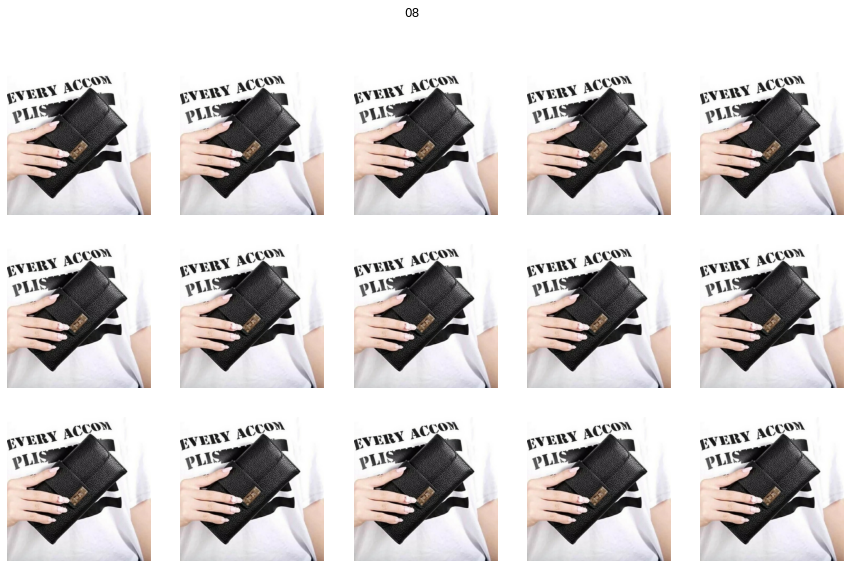

In [17]:
# run again to see different batch of image
show_augmented_image()

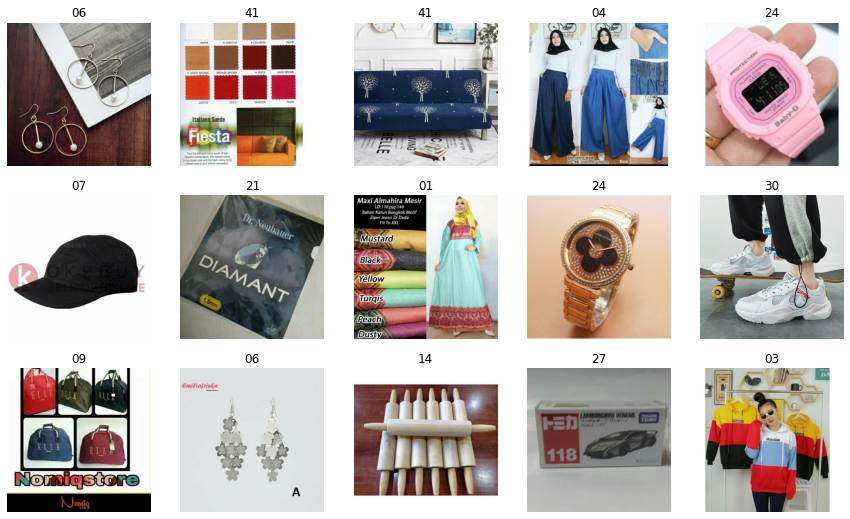

In [18]:
# run again to see different image
show_augmented_image(same_image=False)

# Functions for model training

In [19]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, AveragePooling2D, GlobalAveragePooling2D, SpatialDropout2D, BatchNormalization, Activation, Concatenate

In [20]:
def plt_lr(epoch_count):
    if epoch_count > 50:
        epoch_count = 50
    
    rng = [i for i in range(epoch_count)]

    plt.figure()
    y = [lrfn(x) for x in rng]
    plt.title(f'Learning rate schedule: {y[0]} to {y[epoch_count-1]}')
    plt.plot(rng, y)

def plt_acc(h):
    plt.figure()
    plt.plot(h.history["sparse_categorical_accuracy"])
    if 'val_sparse_categorical_accuracy' in h.history:
        plt.plot(h.history["val_sparse_categorical_accuracy"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.xlabel("epoch")
    plt.title("Sparse Categorical Accuracy")
    plt.show()

def plt_loss(h):
    plt.figure()
    plt.plot(h.history["loss"])
    if 'val_loss' in h.history:
        plt.plot(h.history["val_loss"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.legend(["training","validation"])
    plt.xlabel("epoch")
    plt.title("Loss")
    plt.show()

In [21]:
class EpochCallback(tf.keras.callbacks.Callback):  
    def on_epoch_begin(self, epoch, logs=None):
        global current_epoch
        global chance

        current_epoch = epoch       
        if current_epoch < 2:
            chance = 0
        elif current_epoch < 9:
            chance = current_epoch - 1
        else:
            chance = 8
        print(f'Epoch #{current_epoch}')


In [22]:
es_val_acc = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=5, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)

es_val_loss = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)

es_acc = tf.keras.callbacks.EarlyStopping(
    monitor='sparse_categorical_accuracy', min_delta=0.001, patience=5, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)

es_loss = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.001, patience=5, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)

epoch_cb = EpochCallback()

# Create model

## EfficientNetB7 model

| Layer     | Layer Type                   |
| --------- | ---------------------------- |
| 0         | input_1 (InputLayer)         |
| 1         | stem_conv (Conv2D)           |
| 2         | stem_bn (BatchNormalization) |
| 3         | stem_activation (Activation) |
| 4-49      | block1*                      |
| 50 - 152  | block2*                      |
| 153 - 255 | block3*                      |
| 256 - 403 | block4*                      |
| 404 - 551 | block5*                      |
| 552 - 744 | block6*                      |
| 745 - 802 | block7*                      |
| 803       | top_conv (Conv2D)            |
| 804       | top_bn (BatchNormalization)  |
| 805       | top_activation (Activation)  |

In [23]:
with strategy.scope():
    # phase 1
    efn7 = efn.EfficientNetB7(weights='noisy-student', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    for layer in efn7.layers:
        layer.trainable = True

    model_image = Sequential([
        efn7,
        GlobalAveragePooling2D(name='efficientnet-b7_gap'),
    ], name='b7-image')

    model_words = Sequential([
        Input((6633, ), name='mlp-words_input'),

        Dense(331, name='mlp-words_dense_1'),
        BatchNormalization(name='mlp-words_bn_1'),
        Activation('relu', name='mlp-words_act_1'),

        Dense(110, name='mlp-words_dense_2'),
        BatchNormalization(name='mlp-words_bn_2'),
        Activation('relu', name='mlp-words_act_2'),
    ], name='mlp-words')
    concatenate = Concatenate(name='concatenate')([model_image.output, model_words.output])
    output = Dense(len(CLASSES), activation='softmax', name='output')(concatenate)

    model = Model(inputs=[model_image.input, model_words.input], outputs=output)

    # phase 2
#     model = tf.keras.models.load_model('/kaggle/input/train-phase-1-085009/model.h5')
#     model.load_weights('/kaggle/input/train-phase-1-085009/model_weights.h5')

    model.compile(optimizer=tfa.optimizers.LAMB(0.01), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

model.summary()

258072576/258068648 [==============================] - 11s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mlp-words_input (InputLayer)    [(None, 6633)]       0                                            
__________________________________________________________________________________________________
mlp-words_dense_1 (Dense)       (None, 331)          2195854     mlp-words_input[0][0]            
__________________________________________________________________________________________________
mlp-words_bn_1 (BatchNormalizat (None, 331)          1324        mlp-words_dense_1[0][0]          
__________________________________________________________________________________________________
mlp-words_act_1 (Activation)    (None, 331)          0           mlp-words_bn_1[0][0]             
__________________________

In [24]:
print(f'Pre training time : {(datetime.now() - PRE_TRAINING_TIME_START).total_seconds()} seconds')

Pre training time : 133.742879 seconds


# Training model

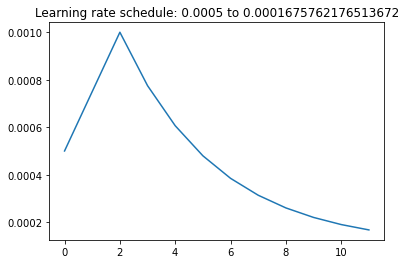

In [25]:
LR_START = 0.0005
LR_MAX = 0.001
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.75 #0.91

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

plt_lr(EPOCHS)
# plt_lr(EPOCHS+EPOCHS)

In [26]:
model.fit(
    get_training_dataset(do_aug=DO_AUG), steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[es_acc, epoch_cb, lr_schedule], verbose=1
)

Epoch #0

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 1/12
411/411 [==============================] - 768s 2s/step - loss: 1.4951 - sparse_categorical_accuracy: 0.6367 - lr: 5.0000e-04
Epoch #1

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00075.
Epoch 2/12
411/411 [==============================] - 771s 2s/step - loss: 0.7341 - sparse_categorical_accuracy: 0.7992 - lr: 7.5000e-04
Epoch #2

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/12
411/411 [==============================] - 772s 2s/step - loss: 0.5951 - sparse_categorical_accuracy: 0.8336 - lr: 0.0010
Epoch #3

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007750000000000001.
Epoch 4/12
411/411 [==============================] - 771s 2s/step - loss: 0.4359 - sparse_categorical_accuracy: 0.8745 - lr: 7.7500e-04
Epoch #4

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00060625.
Epoch 5/12
411/411 [======================

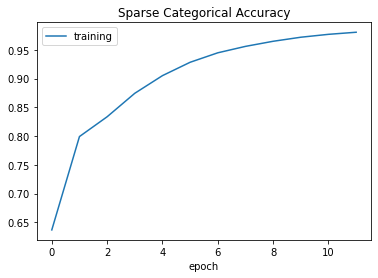

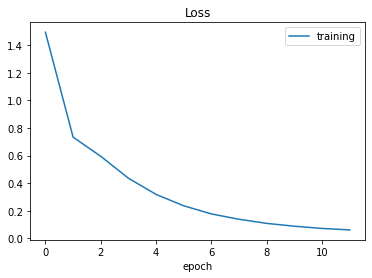

In [27]:
h = model.history
plt_acc(h)
plt_loss(h)

In [28]:
POST_TRAINING_TIME_START = datetime.now()

# Submit Result

In [29]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda iw, filename: [iw])
model_pred = model.predict(test_images_ds)

predictions = np.argmax(model_pred, axis=-1)
print(predictions)

Computing predictions...
[20  4 10 ... 35 13 31]


In [30]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

test_ids_ds = test_ds.map(lambda iw, filename: filename).unbatch()
test_ids = next(iter(test_ids_ds.batch(predictions.shape[0]))).numpy().astype('U') # all in one batch

df_submission = pd.DataFrame({'filename': test_ids, 'category': predictions})
df_submission = df_submission.drop_duplicates()
df_submission['category'] = df_submission['category'].apply(lambda c: str(c).zfill(2))
df_submission

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20
1,cce40cdfd9ef53882386d319d3179696.jpg,04
2,5989e05d9f73748f938a6da6b9d5fd7c.jpg,10
3,0c95bf0651bd02f7a5a193b9f430ed52.jpg,33
4,eaa93b6461bfa7868273b759b9e3c125.jpg,23
...,...,...
12181,3feb40ea8c99f2b0c3d6a1bcaca7f8cf.jpg,18
12182,ceb6db5d91b0e0934f25b9a97a0b0d4e.jpg,37
12183,18cbecd37fa0eb34743070354edd01f8.jpg,34
12184,f9d85e33f40d1702ec514e5e82cd3f6c.jpg,40


In [31]:
print('Generating submission.csv file...')
df_submission.to_csv('submission.csv', index=False)
!head submission.csv

Generating submission.csv file...
filename,category
fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20
cce40cdfd9ef53882386d319d3179696.jpg,04
5989e05d9f73748f938a6da6b9d5fd7c.jpg,10
0c95bf0651bd02f7a5a193b9f430ed52.jpg,33
eaa93b6461bfa7868273b759b9e3c125.jpg,23
3d7b10a9f6d55bbd14a72d803aec2ce4.jpg,05
24fb326378e62fa541ee7f0f3d329afa.jpg,28
a76a602031927190740b582ee87d3bf8.jpg,07
cf5441e526c9db16787de0277938be76.jpg,39


In [32]:
model.save('model.h5')
model.save_weights('model_weights.h5')

In [33]:
print(f'Post training time : {(datetime.now() - POST_TRAINING_TIME_START).total_seconds()} seconds')

Post training time : 85.999013 seconds
